# Design and Optimization of Phase Change Material Composites for Thermal Management

This notebook presents the visualization, design variable influence (volume fraction composition) and Bayesian Optimization of finite element analysis data for composite heatsinks, and is useful to design the most efficient heatsink for transient heat applications. Various statistical methods are utilized for visualization and optimization of the volume fraction.

In [8]:
# Importing required packages
import pandas as pan
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as mpp
import skopt
from functools import partial
from skopt.plots import plot_evaluations
from skopt import Optimizer
from skopt.acquisition import gaussian_ei
from skopt.learning import GaussianProcessRegressor
import seaborn as sns; sns.set()

## Loading the primary and preliminary datasests

The following code loads the primary and preliminary datasets. This is completed throught he use of Pandas. 

The uploaded data must have the following column location and headers, with each row representing a sample. 

Column Number  |Column Header
-------------- | -------------
       1       |     VF1
       2       |     VF2
       3       |     VF3
       4       |     VF4
       5       |     VF5
       6       |     VF6
       7       |     VF7
       8       |     VF8
       9       |     VF9
      10       |     VF10
      11       |     VF11
      12       |     VF12
      13       |     VF13
      14       |     VF14
      15       |     VF15
      16       |     VF16
      17       |     VF17
      18       |     VF18
      19       |     VF19
      20       |     VF20
      21       |    Q 1000

In [14]:
## Importing Data
alldata = pan.read_excel('DT1LHS_250_500_1000_VF_Q_Final.xlsx')
PCAdata = pan.read_excel('500pointsDT1LHS_250_500_1000_VF_Q_Final.xlsx')
print ('Data file(s) were successfully loaded')
dimensions = []
allheaders = list(alldata.columns.values)
headersX0 = allheaders[:-3]
headersY0 = allheaders[-3:]
xinitial= alldata[headersX0]
yinitial= alldata[headersY0]

Data file(s) were successfully loaded


## Data Visualtization

In the next section we aim to visualize the design space, however due to the 20 dimensions, 2D representation of the first two, middle two and last two volume fractions in the design space. This data is plotted from the smaller dataset that will be used later to determine the relationships between design variables. 

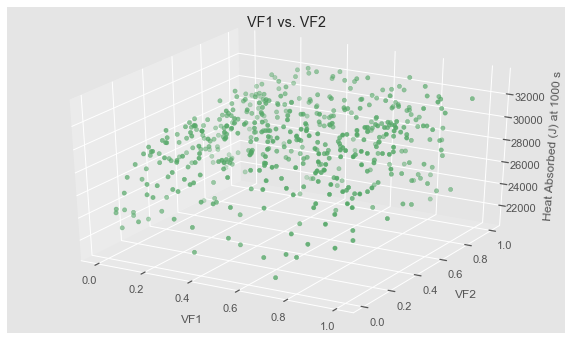

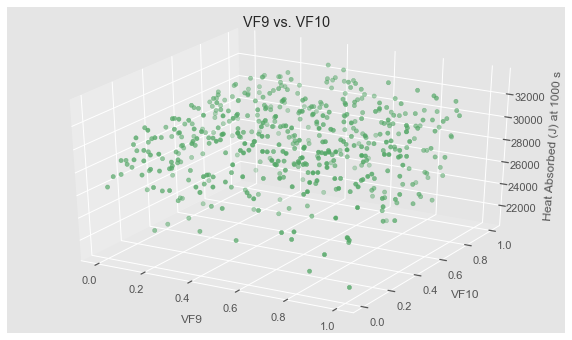

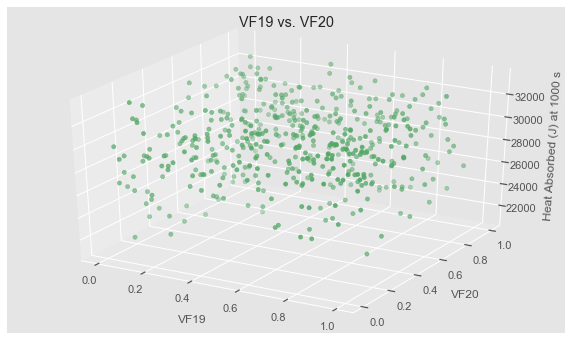

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

mpp.style.use('ggplot')

#VF1 vs VF2 vs Qs
fig1 = mpp.figure(figsize=(10, 6), facecolor='w')
ax1 = fig1.gca(projection='3d')
ax1.scatter(PCAdata['VF1'], PCAdata['VF2'], PCAdata[headersY0[2]] , c='g',marker= '8')
ax1.set_xlabel('VF1')
ax1.set_ylabel('VF2')
ax1.set_title('VF1 vs. VF2')
ax1.set_zlabel('Heat Absorbed (J) at 1000 s')
ax1.xaxis.labelpad=10
ax1.yaxis.labelpad=10
ax1.zaxis.labelpad=6
mpp.show()
fig1.savefig("heatVF1 & VF2 surface.png", bbox_inches='tight', dpi=600)

#VF9 vs VF10 vs Qs
fig2 = mpp.figure(figsize=(10, 6), facecolor='w')
ax2 = fig2.gca(projection='3d')
ax2.scatter(PCAdata['VF9'], PCAdata['VF10'], PCAdata[headersY0[2]] , c='g',marker= '8')
ax2.set_xlabel('VF9')
ax2.set_ylabel('VF10')
ax2.set_title('VF9 vs. VF10')
ax2.set_zlabel('Heat Absorbed (J) at 1000 s')
ax2.xaxis.labelpad=10
ax2.yaxis.labelpad=10
ax2.zaxis.labelpad=6
mpp.show()
fig2.savefig("heatVF9 & VF10.png", bbox_inches='tight', dpi=600)

#VF19 vs VF20 vs Qs
fig3 = mpp.figure(figsize=(10, 6), facecolor='w')
ax3 = fig3.gca(projection='3d')
ax3.scatter(PCAdata['VF19'], PCAdata['VF20'], PCAdata[headersY0[2]] , c='g',marker= '8')
ax3.set_xlabel('VF19')
ax3.set_ylabel('VF20')
ax3.set_title('VF19 vs. VF20')
ax3.set_zlabel('Heat Absorbed (J) at 1000 s')
ax3.xaxis.labelpad=10
ax3.yaxis.labelpad=10
ax3.zaxis.labelpad=6
mpp.show()
fig3.savefig("heatVF19 & VF20.png", bbox_inches='tight', dpi=600)

## Design Variable Influence

The next section of the code is used for correlation and principal component analysis to determine possible realationships between the design variables (radial volume fractions). 

### Correlation Analysis 

The correlation coefficient between all of the design variable (volume fractions) was calculated to determine if there is any relationship that can be utilitzed to reduce the dimensionality of the design space. 

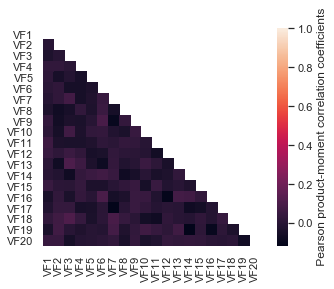

In [16]:
#Coreelation Analysis
correlation= PCAdata[headersX0]
corr = np.corrcoef(PCAdata[headersX0], rowvar=False)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, xticklabels=headersX0, yticklabels=headersX0, square=True, cbar_kws={'label': ' Pearson product-moment correlation coefficients'}) 
fig = ax.get_figure()
fig.savefig("thermalmap.png", dpi=600)

From the plot above, we obsereve that there is no correlation between any of the design variables. Thus we can not reduce the design varible space through linear relationships. Next we consider a dimensionality reduction utilizing principal component analysis. 

### Principal Component Analysis

Principal component analysis was next utilized to determine if the dimensionality can be reduced by using a smaller number of principal components (while maintaining the explained variance of the system).

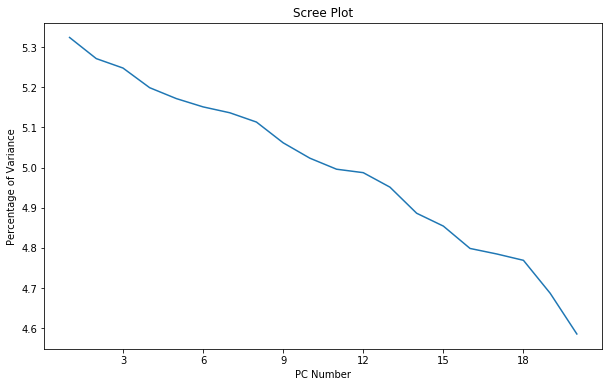

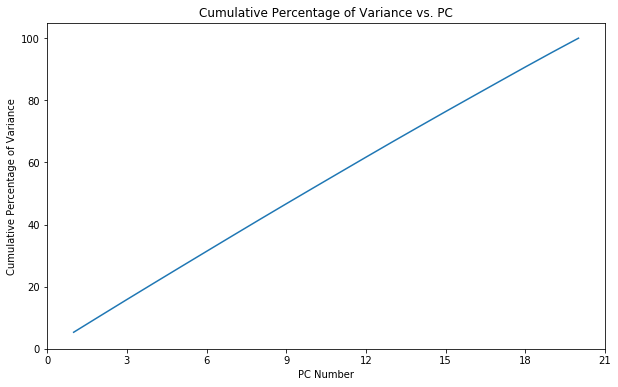

In [7]:
#Principal Component Analysis
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
PCA = PCA(n_components=20)
fitPCA=PCA.fit(xinitial)
variances= PCA.explained_variance_ratio_
cumsumvar=np.cumsum(100*variances)
pervariances=100*variances
PCnum=np.linspace(1, 20, 20)

### Scree Plot
fig4 = mpp.figure(figsize=(10, 6), facecolor='w')
ax4 = fig4.gca()
mpp.plot (PCnum,pervariances)
mpp.title('Scree Plot')
mpp.xlabel('PC Number')
mpp.ylabel('Percentage of Variance')
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
mpp.show()
fig4.savefig("scree plot1.png", bbox_inches='tight', dpi=600)

### Cumulative Percentage Plot
fig10 = mpp.figure(figsize=(10, 6), facecolor='w')
ax10 = fig10.gca()
mpp.plot (PCnum,cumsumvar)
mpp.title('Cumulative Percentage of Variance vs. PC')
mpp.xlabel('PC Number')
mpp.ylabel('Cumulative Percentage of Variance')
mpp.xlim(0, 21)
mpp.ylim(0, 105)
ax10.xaxis.set_major_locator(MaxNLocator(integer=True))
mpp.show()
fig10.savefig("percent variance vs pc1.png", bbox_inches='tight', dpi=600)

As seen above, there is not one principal compenent that explains the majority of variance in the system. Additionally, 90% of the variance is expalined using the first 18 principal components. This would lead to a slight loss of information in the system while also only reducing the dimensionality from 20 to 18, which is not significant. Moving forward all 20 volume fractions are considered. 

## Bayesian Optimization

In this section, we will fit a Gaussian process regressor to our primary dataset (10,000 data points) and then using an expected improvement aquistion function will determine the next volume fractions to sample. 

### Fitting the Gaussian  Process Regressor

The first step for Bayesian Optimization is fitting the Gaussian Process Regressor to the primary (10,000 data points) dataset. This is accomplished by setting the initial data of the optimizer equal to the values o fthe primary data set. 

In [18]:
#Fitting the Gaussian  Process Regressor
dimensions= np.repeat([[0.001,1]], 20, axis=0)
opt= Optimizer(dimensions= dimensions, base_estimator='gp', n_initial_points=1, acq_func='EI', acq_optimizer='sampling')
Optimizer.Xi=xinitial
Optimizer.yi=-1*yinitial['Q 1000']

### Predicting Using Expected Improvement

Next, the expected improvement acquisition function is utilized to detemine the next sampling point from the Gaussian surface. The performance metric for that point is determined and used to refit the Gaussian surface. This process is repeated until a maximum value is identified. 

In [19]:
#Optimization Cycles
headers= np.append(headersX0, 'Q 1000')
predicted_data=0
predicted_data= pan.DataFrame(np.nan, index=range(200), columns=headers)
data = 0
i= 0
con = 1
while con == 1:
    next_x = opt.ask()
    data=np.append(next_x, 0)
    predicted_data.loc[i] = data.reshape((1, -1))
    predicted_data.to_excel("predicted data" + str(i+1) + ".xlsx")
    Q= -1* float(input ('What is the heat absorbed (J) at 1000s for this composition?'))
    predicted_data.loc[i, 'Q 1000'] = Q
    opt.tell(next_x, Q)
    print ('Iteration number ',  i+1, ' completed')
    con= int(input ('Would you like to continue? '+ 'yes = 1'+ ' or '+ 'no = 2: '))
    next_x=0
    data=0
    i = i+1
print (i, " iterations have been completed.")
predicted_data.head(i)
predicted_data.to_excel("final predicted data.xlsx")

What is the heat absorbed (J) at 1000s for this composition?22698.08
Iteration number  1  completed
Would you like to continue? yes = 1 or no = 2: 2
1  iterations have been completed.


### Visualization of Optimized Results

Finally, the original 10,000 data points are plotted with the newly predicted points. This shows that the optimal value has not been reached with 25 iterations. Further iterations are requried to optimize the system. 

First, the data for the first volume fraction (VF1) which is closest to the heat source is plotted. 

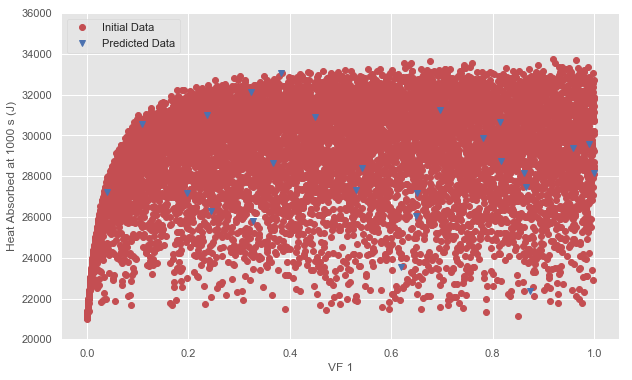

In [22]:
#Plotting the optimized results vs. primary data set
predicteddata= pan.read_excel('final predicted data.xlsx')
i = 0
dimensions = []
allheaders = list(alldata.columns.values)
headersX0 = allheaders[:-3]
headersY0 = allheaders[-3:]
xinitial= alldata[headersX0]
fig1 = mpp.figure(figsize=(10, 6), facecolor='w')
ax1 = fig1.gca()
mpp.plot(alldata[headersX0[0]], alldata[headersY0[2]], 'ro', label='Initial Data')
mpp.plot(predicteddata[headersX0[0]], -1*predicteddata[headersY0[2]], 'bv', label='Predicted Data')
mpp.ylim(20000,36000)
mpp.xlabel('VF 1')
mpp.ylabel('Heat Absorbed at 1000 s (J)')
mpp.legend(loc=2)
mpp.show()
fig1.savefig("VF 1 Data ", bbox_inches='tight', dpi=600)

Next, the volume fraction at the center of the heatsink (VF10) is plotted. 

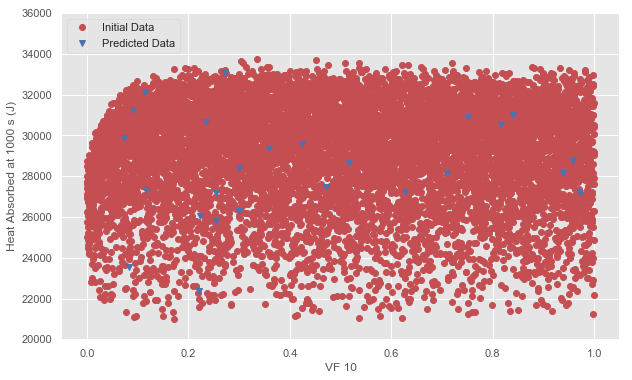

In [23]:
fig2 = mpp.figure(figsize=(10, 6), facecolor='w')
ax2 = fig2.gca()
mpp.plot(alldata[headersX0[9]], alldata[headersY0[2]], 'ro', label='Initial Data')
mpp.plot(predicteddata[headersX0[9]], -1*predicteddata[headersY0[2]], 'bv', label='Predicted Data')
mpp.ylim(20000,36000)
mpp.xlabel('VF 10')
mpp.ylabel('Heat Absorbed at 1000 s (J)')
mpp.legend(loc=2)
mpp.show()
fig2.savefig("VF 10 Data ", bbox_inches='tight', dpi=600)

Finally, the volume fraction furthest from the heat source is plotted. 

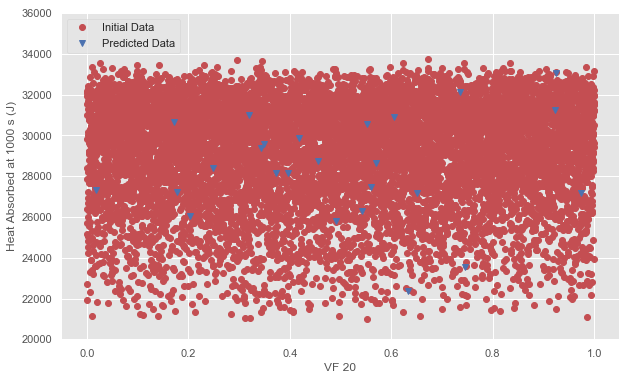

In [24]:
fig3 = mpp.figure(figsize=(10, 6), facecolor='w')
ax3 = fig3.gca()
mpp.plot(alldata[headersX0[19]], alldata[headersY0[2]], 'ro', label='Initial Data')
mpp.plot(predicteddata[headersX0[19]], -1*predicteddata[headersY0[2]], 'bv', label='Predicted Data')
mpp.ylim(20000,36000)
mpp.xlabel('VF 20')
mpp.ylabel('Heat Absorbed at 1000 s (J)')
mpp.legend(loc=2)
mpp.show()
fig3.savefig("VF 20 Data ", bbox_inches='tight', dpi=600)